In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from quaternion2 import Quaternion

In [2]:
# Load data
data_num = 1

imu_data = io.loadmat(f'imu/imuRaw{data_num}.mat')
vicon_data = io.loadmat(f'vicon/viconRot{data_num}.mat')

accel_raw = np.array(imu_data['vals'])[0:3].astype('float64') 
vicon_rotations = vicon_data['rots']

imu_timestamps = imu_data['ts'][0]
vicon_timestamps = vicon_data['ts'][0]

gravity = np.array([0, 0, 9.81])

In [3]:
#directions of x and y are inverted
accel_raw[0] *= -1
accel_raw[1] *= -1

In [4]:
#find smaller of vicon and accel data and truncate rest
min_length = min(vicon_rotations.shape[2], accel_raw.shape[1])

imu_timestamps = imu_timestamps[:min_length]
vicon_timestamps = vicon_timestamps[:min_length]
vicon_rotations = vicon_rotations[:,:min_length]
accel = accel_raw[:,:min_length]

In [5]:
#calculate expected acceleration based on vicon data
expected_accel_readings = []
gravity_quat = Quaternion(0, gravity)
for i in range(vicon_rotations.shape[2]):
    q = Quaternion()
    q.from_rotm(vicon_rotations[:,:,i])
    expected_gravity = q.inv()*gravity_quat*q
    expected_accel_readings.append(expected_gravity.vec())

expected_accel_readings = np.array(expected_accel_readings)

In [6]:
#calculate bias based on points in which there is no movement
bias_accel = np.mean(accel.T[:10], axis=0)

#use average of x and y biases to calculate z bias
bias_accel[2] = abs(bias_accel[0]+bias_accel[1])/2

print(bias_accel)

#since we know the sensitivity should result in acceleration 9.81 when stationary, solve for sensitivity
sensitivity_accel = np.mean((accel.T - bias_accel)[:100,2] * (3300/(1023)) / 9.81)

print(sensitivity_accel)

accel_physical = ((accel.T - bias_accel) * (3300/(1023 *sensitivity_accel))).T

[-510.9  -501.    505.95]
32.61319917135248


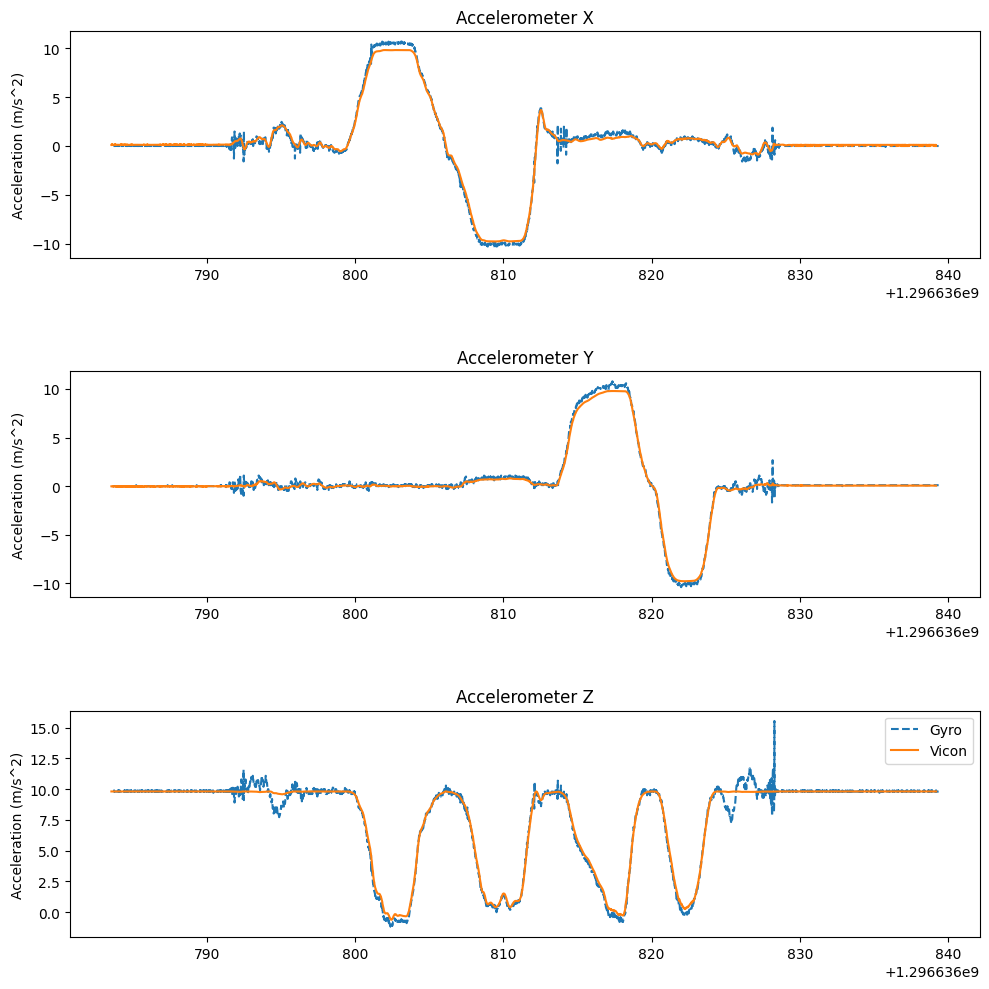

In [7]:
plt.figure(3, figsize=(10,10))
plt.subplot(3, 1, 1)
plt.plot(imu_timestamps, accel_physical[0].T, label='Gyro', linestyle='--')
plt.plot(vicon_timestamps, expected_accel_readings[:,0], label='Vicon', linestyle='-')
plt.title('Accelerometer X')
plt.ylabel('Acceleration (m/s^2)')

plt.subplot(3, 1, 2)
plt.plot(imu_timestamps, accel_physical[1].T, label='Gyro', linestyle='--')
plt.plot(vicon_timestamps, expected_accel_readings[:,1], label='Vicon', linestyle='-')
plt.title('Accelerometer Y')
plt.ylabel('Acceleration (m/s^2)')


plt.subplot(3, 1, 3)
plt.plot(imu_timestamps, accel_physical[2].T, label='Gyro', linestyle='--')
plt.plot(vicon_timestamps, expected_accel_readings[:,2], label='Vicon', linestyle='-')
plt.title('Accelerometer Z')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.tight_layout()

plt.subplots_adjust(hspace=0.5) 

plt.show()